# Results wPCC inverse dynamics

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper

In [2]:
ship_name = "wPCC"

In [6]:
loaders = {
    "polynomial rudder" : catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL")['simple'],
    "semiempirical rudder" : catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia'],
}

[10/30/24 09:19:37] INFO     Loading data from 'wPCC.models_VCT_polynomial_rudder_MDL'          ]8;id=784735;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=196671;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=711676;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=114082;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=525822;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=238702;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [7]:
models = {name:loader() for name,loader in loaders.items()}

## ID

In [12]:
meta_data_all = catalog.load(f"{ship_name}.time_series_meta_data")
id_exists = [int(key) for key in catalog.load(f"{ship_name}.tests_ek_smooth1").keys()]
meta_data_all = meta_data_all.loc[id_exists].copy()
#ids = [int(key) for key in catalog.load("wPCC.tests_ek_smooth1").keys()]
ids = [
        22773,
        22772,
        22770,
        22765,
        #22774,
    ]

meta_datas = meta_data_all.loc[ids].copy()

[10/30/24 09:23:52] INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=517925;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=474279;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=433821;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=645396;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [13]:
styles={'Experiment':{'style':'k-','label':'Experiment'}}
styles.update({key:{'label':key,'style':'--',} for key in models.keys()})

[10/30/24 09:31:46] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=382909;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=178543;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[10/30/24 09:31:47] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=412161;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=167206;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[10/30/24 09:31:48] INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=946685;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=17331;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth1' (PartitionedDataset)...  ]8;id=513727;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=629383;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

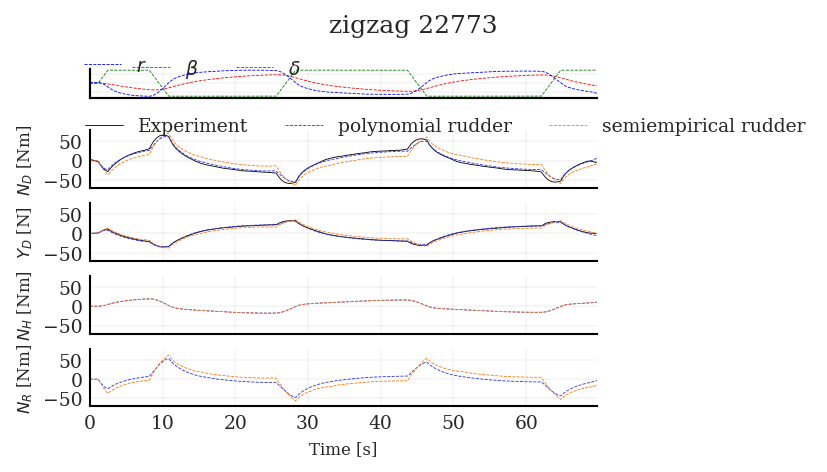

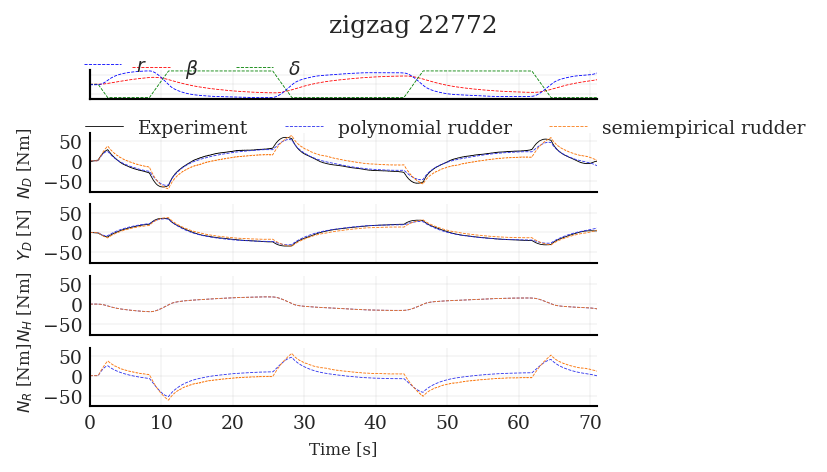

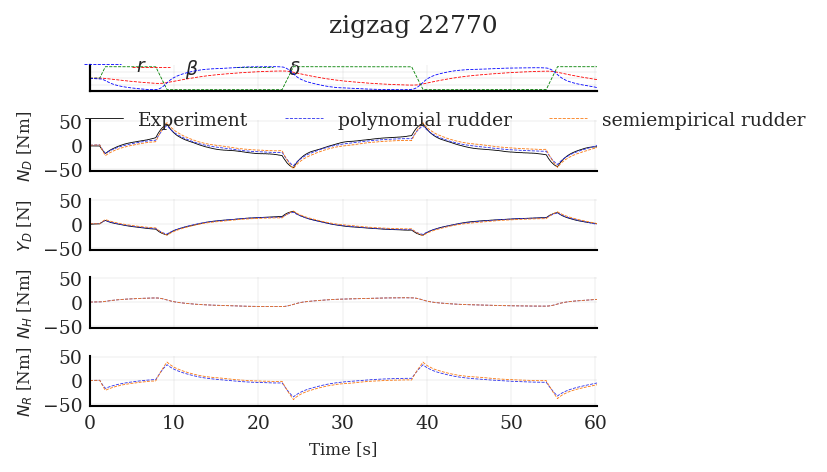

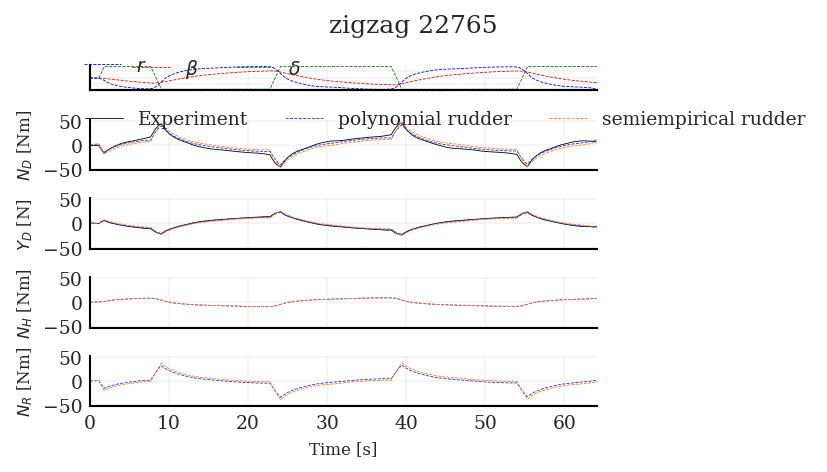

In [25]:
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load("wPCC.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    df_EKF_smooth['thrust'] = df_EKF_smooth['thrust_port'] + df_EKF_smooth['thrust_stbd']
    #data = load(id=id, catalog=catalog, smooth=False)
    #data = filter(data,cutoff=1)
    #data = data.iloc[100:-100].copy()

    if id==22774:
        #data=data.loc[0:70].copy()
        df_EKF_smooth = df_EKF_smooth.loc[0:70].copy()


    fig = plot_compare_model_forces(model=models['polynomial rudder'], models=models, data=df_EKF_smooth, styles=styles, keys=['N_D','Y_D','N_H','N_R'], delta_corners=False);
    #fig = plot_compare_model_forces(model=models["ID small"], models=models, data=df_EKF_smooth, styles=styles, keys=['N_VCT','Y_VCT','N_H','N_R'], delta_corners=False);
    
    fig.axes[-1].legend(loc='upper center', bbox_to_anchor=(0.05, 2.0), ncol=1)
    fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.25, 2.0), ncol=3)
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.70, 1.52), ncol=3)
    #fig.axes[1].legend(bbox_to_anchor=(0.7, 1.5), ncol=5)
    #fig.axes[1].legend(ncol=3)
    
    for ax in fig.axes[1:5]:
        ylims = ax.get_ylim()
        ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
        ax.set_ylim(ylims)
    
    fig.suptitle(f"{meta_data['test_type']} {id}")

    #plt.tight_layout()
